В этой лабораторной работе вам предлагается решить задачу бинарной классификации на наборе данных Titanic с помощью фреймворка глубокого обучения TensorFlow.

Давайте убедимся, что необходимые нам для этой работы библиотеки уже установлены.

In [ ]:
!pip install tensorflow -U --q

In [ ]:
!pip install numpy tensorflow_datasets --q

In [ ]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, f1_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(
    style="whitegrid",
    font_scale=0.8,
    rc={
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'legend.fontsize': 10,
        'grid.color': '#e5e5e5',
        'grid.linestyle': '--',
        'grid.linewidth': 0.7,
        'axes.grid': True,
        'figure.autolayout': True,
        'figure.figsize': (8, 4)
       }
)

# Описание набора данных
В данной работе целью исследования будет набор данных Titanic. Данный набор содержит информацию о различных пассажирах корабля "Титаник", затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д. Мы предлагаем вам натренировать нейронную сеть для бинарной классификации, способную предсказывать вероятность спасения человека на основе его данных.  

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы - отдельный пассажир, вся информация о нем содержится в его строке. В столбце survived находится бинарная метка (0 или 1), означающая, спасся ли человек с корабля (1) или нет (0). Вашей задачей является изучить набор данных, корректно определить решаемую задачу, а затем построить модель, которая будет способна предсказывать вероятность спасения и посчитать F1-метрику на тестовом наборе данных.

Для загрузки набора данных мы снова будем использовать библиотеку tensorflow_datasets.

Импортируем данную библиотеку, а затем с помощью нее загрузим набор данных "titanic". В процессе загрузки сразу разделим его на тренировочную, валидационную и тестовую выборку.

In [ ]:
import tensorflow_datasets as tfds
ds_train_tf, ds_validation_tf, ds_test_tf = tfds.load(
    name='titanic',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True
)

По умолчанию библиотека загружает данные в формате TensorFlow Dataset. Этот формат позволяет оперировать данными на жестком диске без предварительной загрузки их в память, что позволят обучать модели на данных, превышающих размер оперативной памяти вашего устройства.

Набор данных Titanic является достаточно небольшим набором и мы уверены, что оперативной памяти вашего устройства хватит для хранения его целиком, поэтому это в данный момент не играет решающей роли. Однако, вам будет полезно научиться работать с ним.

Примеры использования и различных функций этого формата данных вы можете найти в документации Keras.

Давайте выведем первую строку тренировочного набора данных для ознакомления.

In [ ]:
for x, y in ds_train_tf.take(1):
    print(f"{x=}")
    print(f"{y=}")

x={'age': <tf.Tensor: shape=(), dtype=float32, numpy=30.0>, 'boat': <tf.Tensor: shape=(), dtype=string, numpy=b'Unknown'>, 'body': <tf.Tensor: shape=(), dtype=int32, numpy=-1>, 'cabin': <tf.Tensor: shape=(), dtype=string, numpy=b'Unknown'>, 'embarked': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'fare': <tf.Tensor: shape=(), dtype=float32, numpy=13.0>, 'home.dest': <tf.Tensor: shape=(), dtype=string, numpy=b'Sarnia, ON'>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'McCrie, Mr. James Matthew'>, 'parch': <tf.Tensor: shape=(), dtype=int32, numpy=0>, 'pclass': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sibsp': <tf.Tensor: shape=(), dtype=int32, numpy=0>, 'ticket': <tf.Tensor: shape=(), dtype=string, numpy=b'233478'>}
y=<tf.Tensor: shape=(), dtype=int64, numpy=0>


Как можно заметить, формат текущего датасета представляет собой кортеж из двух элементов - признаков и метки класса. Признаки организованы как словарь с ключами (названиями признаков) и значениями признаков. Данный формат можно использовать напрямую для метода model.fit, однако признаки, несомненно, требуют предобработки.

Итак, к настоящему моменту мы загрузили набор данных, разделили его на тренировочную, валидационную и тестовую выборку и готовы приступить к решению задачи. Вашим финальным заданием является получение максимального значения F1-метрики на тестовом наборе данных, используя все возможности по изучению и визуализации данных, предобработке данных, а также нейронную сеть, выполненную с помощью фреймворка TensorFlow (и его части - Keras).  

Для того, чтобы напомнить процесс подготовки данных и обучения модели, мы поместили несколько ячеек с комментариями ниже в предполагаемом порядке. Однако, вы можете использовать любой удобный вам процесс.  

В процессе исследования и тренировки запрещено использовать данных из ds_test кроме как для финальной оценки F1 метрики. Данная лабораторная работа служит не для проверки ваших навыков, а для того, чтобы вы могли оттачить навыки обучения НС и работы с соответствующими библиотеками. Мы просим вас попытаться решить задачу самостоятельно, не используя доступную информацию из ds_test набора и не пытаясь подогнать модель под идеальную работу с конкретно данным набором, а также просим не использовать внешние источники данных и информацию из соответствующих соревнований на платформе Kaggle.

Вы можете найти для себя полезным пройти снова ноутбук с описанием работы фреймворка Keras и информацией о том, как его использовать. Также по данному фреймворку доступны многочисленные туториалы и примеры на его сайте. Напомним вам, что задача представляет собой бинарную классификацию, поэтому вам необходимо выбрать правильное количество нейронов для последнего слоя и функцию активации.

Успехов!

# Предобработка данных

## 1. Предобработка данных: заполнение пропущенных мест, приведение столбцов к единому виду, удаление nan/infinity значений

Для более удобного использования извлечем данные из tensorflow dataset в pandas DataFrame:

In [ ]:
def preprocessing(datasets):
    extracted_dataset = []
    labels = []

    for data in datasets:
        for example, label in tfds.as_numpy(data):
            extracted_dataset.append(example)
            labels.append(label)

    df = pd.DataFrame(extracted_dataset)
    df['survived'] = labels

    return df

Также пока объединим обучающую, тестовую и валидационную выборки:

In [ ]:
datasets = [ds_train_tf, ds_test_tf, ds_validation_tf]
df = preprocessing(datasets)

Размер полученного датафрейма:

In [ ]:
df.shape

(1309, 14)

Посмотрим на 5 рандомных строк, видим пропуски (например, в "boat" -- 'b'Unknown'', "body" -- '-1'), а также неверное представление признаков со строковым типом данных:

In [ ]:
df.sample(5)

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,ticket,survived
1194,34.0,b'Unknown',-1,b'Unknown',2,13.0000,"b'Vancouver, BC'","b'Gillespie, Mr. William Henry'",0,1,0,0,b'12233',0
511,21.0,b'Unknown',-1,b'Unknown',2,8.0500,b'Unknown',"b'Stanley, Mr. Edward Roland'",0,2,0,0,b'A/4 45380',0
969,-1.0,b'Unknown',-1,b'Unknown',1,7.7792,b'Unknown',"b'Shine, Miss. Ellen Natalia'",0,2,1,0,b'330968',1
524,47.0,b'Unknown',275,b'E63',2,38.5000,"b""St Anne's-on-Sea, Lancashire""","b'Gee, Mr. Arthur H'",0,0,0,0,b'111320',0
560,45.0,b'14',-1,b'Unknown',2,26.2500,"b'Ilford, Essex / Winnipeg, MB'","b'Hart, Mrs. Benjamin (Esther Ada Bloomfield)'",1,1,1,1,b'F.C.C. 13529',1


Основные характеристики данных:

In [ ]:
def get_info(df):

    print('Обзор датафрейма:')
    print('Информация о датафрейме:')
    df.info()
    print(' '*50)
    print('Дополнительные характеристики данных в датафрейме:')
    display(df.describe())
    print(' '*50)
    print('Количество пропусков:', end='')
    display(df.isna().mean().T)
    print(' '*50)
    print('Количество дубликатов:')
    print(df.duplicated().sum())
    print()

In [ ]:
get_info(df)

Обзор датафрейма:
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1309 non-null   float32
 1   boat       1309 non-null   object 
 2   body       1309 non-null   int32  
 3   cabin      1309 non-null   object 
 4   embarked   1309 non-null   int64  
 5   fare       1309 non-null   float32
 6   home.dest  1309 non-null   object 
 7   name       1309 non-null   object 
 8   parch      1309 non-null   int32  
 9   pclass     1309 non-null   int64  
 10  sex        1309 non-null   int64  
 11  sibsp      1309 non-null   int32  
 12  ticket     1309 non-null   object 
 13  survived   1309 non-null   int64  
dtypes: float32(2), int32(3), int64(4), object(5)
memory usage: 117.7+ KB
                                                  
Дополнительные характеристики данных в датафрейме:


,age,body,embarked,fare,parch,pclass,sex,sibsp,survived
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,23.676600,13.957219,1.495034,33.269279,0.385027,1.294882,0.355997,0.498854,0.381971
std,17.866207,55.442283,0.816130,51.747536,0.865560,0.837836,0.478997,1.041658,0.486055
min,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,-1.000000,1.000000,7.895800,0.000000,1.000000,0.000000,0.000000,0.000000
50%,24.000000,-1.000000,2.000000,14.454200,0.000000,2.000000,0.000000,0.000000,0.000000
75%,35.000000,-1.000000,2.000000,31.275000,0.000000,2.000000,1.000000,1.000000,1.000000
max,80.000000,328.000000,3.000000,512.329224,9.000000,2.000000,1.000000,8.000000,1.000000


                                                  
Количество пропусков:

,0
age,0.0
boat,0.0
body,0.0
cabin,0.0
embarked,0.0
fare,0.0
home.dest,0.0
name,0.0
parch,0.0
pclass,0.0


                                                  
Количество дубликатов:
0



Как видим пропусков нет (это неправда). Сразу разберемся со значениями, которые должны быть Nan, но на данный момент представлены в другом формате:

In [ ]:
df = df.replace(df.iloc[0, 3], np.nan)
df = df.replace(-1, np.nan)
df = df.replace("?", np.nan)

А теперь выведем количнство пропусков в каждом из признаков:

<BarContainer object of 14 artists>

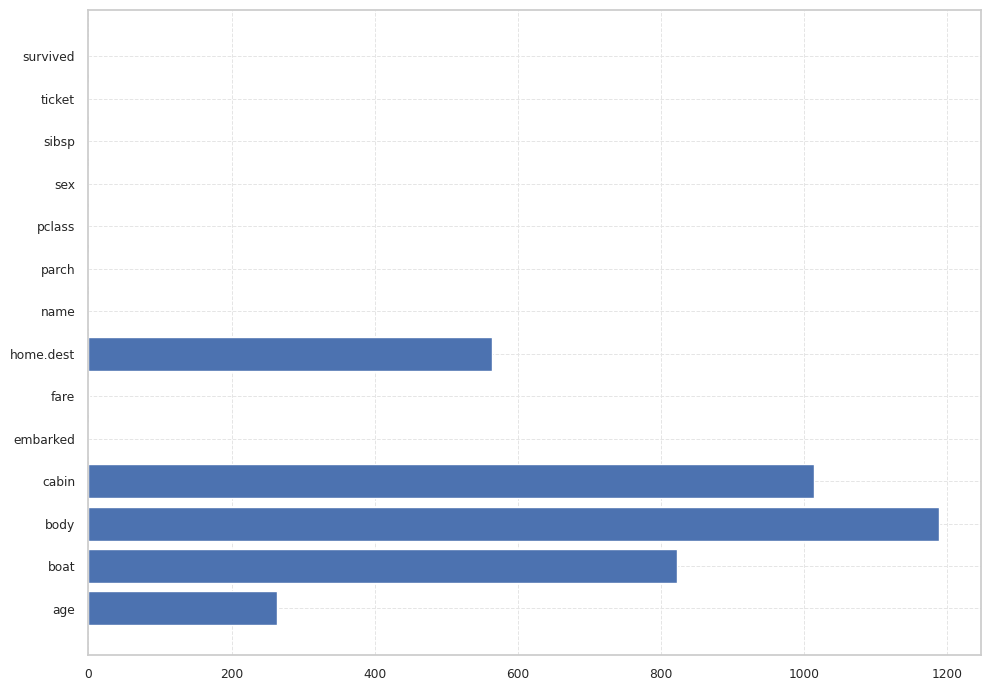

In [ ]:
data = df.isna().sum()

plt.figure(figsize=(10,7))
plt.barh(data.index, data.values)

Признаки boat, body, cabin, home.dest не очень информативные для анализа, так как содержат довольно много пропусков, поэтому удалим их.
С признаком age можно поработать -- будем пробовать заполнить пропуски.

In [ ]:
df.drop(['boat', 'body', 'cabin', 'home.dest'], axis=1, inplace=True)

Посмотрим на матрицу корреляций признаков, оставшихся на данный момент:

In [ ]:
numerical_features = ['age', 'fare', 'sibsp', 'parch']
categorical_features = ['embarked', 'pclass', 'sex']

In [ ]:
sc = StandardScaler()
scaled_features = sc.fit_transform(df[numerical_features + categorical_features + ['survived']])

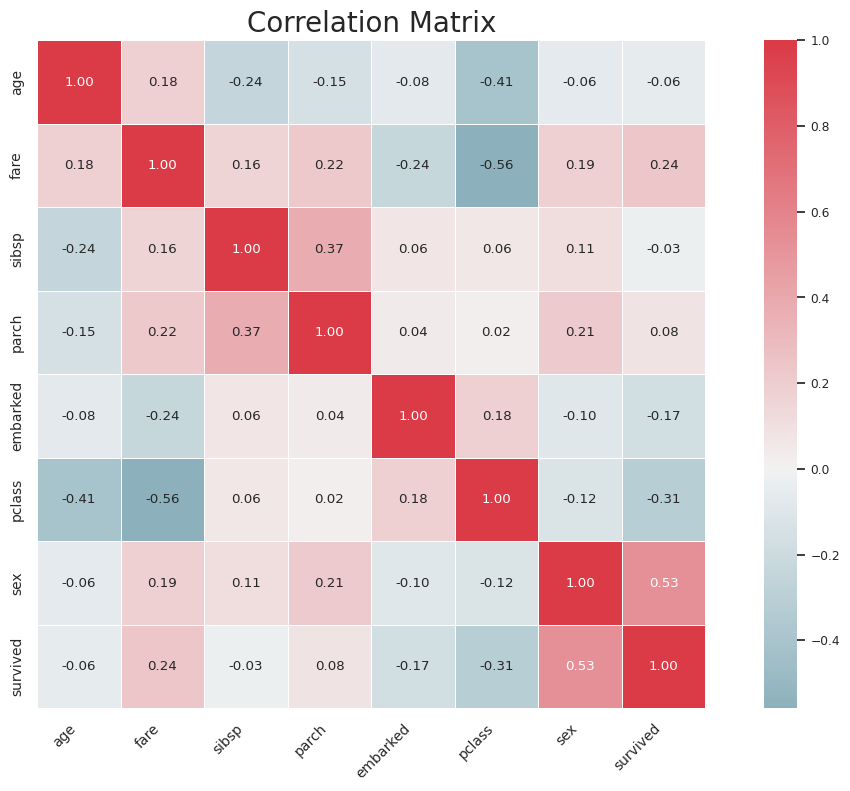

In [ ]:
col = df.columns
numeric_col = list(col)

corr_matrix = pd.DataFrame(scaled_features, columns = numerical_features + categorical_features + ['survived']).corr()

plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, center=0, linewidths=0.5, square=True)
plt.title('Correlation Matrix', size=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

Сильной корреляции между признаками не наблюдается.

Мы видим, что у признака Age есть пропуски. Нужно решить, что с ними делать. Можно удалить строки с пропущенными значениями, но тогда мы можем потерять часть важной информации. Или мы можем заполнить их какими-нибудь значениями: например, среднее, медиана или мода.

<BarContainer object of 98 artists>

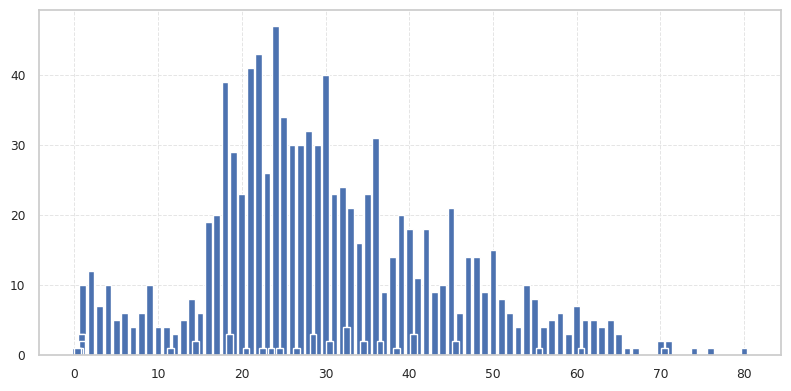

In [ ]:
data = df['age'].value_counts()

plt.bar(data.index, data.values)

In [ ]:
mean_Age = np.mean(df['age'].dropna().values)
median_Age = np.quantile(df['age'].dropna().values,q=0.5)
print(f"Среднее = {mean_Age}")
print(f"Медиана = {median_Age}")

Среднее = 29.881135940551758
Медиана = 28.0


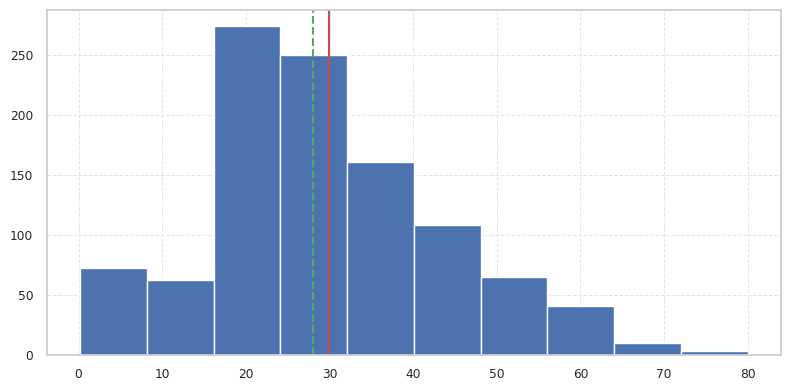

In [ ]:
plt.hist(df['age'])

plt.axvline(x=mean_Age, color='r', linestyle = '-', label='mean')
plt.axvline(x=median_Age, color='g', linestyle = '--', label='median')

plt.show()

Заменим пропуски медианой:

In [ ]:
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)

## 2. Инженерия признаков: генерация или выделение наиболее интересных признаков, удаление ненужных

Ранее были удалены признаки boat, body, cabin, home.dest. Есть еще пара признаков, с которыми нужно поработать -- name и ticket. Выделим title (Miss/Mr/Ms) пассажира:

In [ ]:
df['name'] = df['name'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df['title'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(df['title'], df['sex'])

sex,0,1
title,,
Capt,1,0
Col,4,0
Countess,0,1
Don,1,0
Dona,0,1
Dr,7,1
Jonkheer,1,0
Lady,0,1
Major,2,0


Видим, что есть некоторые титулы, которые встречаются нечасто. Давайте редкие титулы заменим на один класс, назовем его "Rare":

In [ ]:
df['title'] = df['title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df['title'] = df['title'].replace('Mlle', 'Miss')
df['title'] = df['title'].replace('Ms', 'Miss')
df['title'] = df['title'].replace('Mme', 'Mrs')

In [ ]:
df[['title', 'survived']].groupby(['title'], as_index=False).mean()

,title,survived
0,Master,0.508197
1,Miss,0.678030
2,Mr,0.162483
3,Mrs,0.787879
4,Rare,0.379310


Удалим ненужные признаки:

In [ ]:
df.drop(columns=['name', 'ticket'], inplace=True)

In [ ]:
df.head(3)

,age,embarked,fare,parch,pclass,sex,sibsp,survived,title
0,30.0,2,13.000,0,1,0,0,0,Mr
1,37.0,2,7.925,0,2,0,2,0,Mr
2,28.0,2,13.000,0,1,1,0,1,Miss


### Анализ признаков: категориальные и количественные

In [ ]:
df.columns

Index(['age', 'embarked', 'fare', 'parch', 'pclass', 'sex', 'sibsp',
       'survived', 'title'],
      dtype='object')

One Hot Encoding - наиболее распространенный метод кодирования категориальных переменных:

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[['title']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['title']), index=df.index)

df_combined = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_combined.drop('title', axis=1)
df_encoded

,age,embarked,fare,parch,pclass,sex,sibsp,survived,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare
0,30.0,2,13.000000,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0
1,37.0,2,7.925000,0,2,0,2,0,0.0,0.0,1.0,0.0,0.0
2,28.0,2,13.000000,0,1,1,0,1,0.0,1.0,0.0,0.0,0.0
3,18.0,2,73.500000,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0
4,28.0,0,7.895800,0,2,0,0,0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,2,7.312500,0,2,0,0,0,0.0,0.0,1.0,0.0,0.0
1305,38.0,0,71.283302,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0
1306,41.0,0,15.045800,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0
1307,29.0,2,9.500000,0,2,0,0,1,0.0,0.0,1.0,0.0,0.0


Также закодируем переменные embarked, pclass, parch, sibps:

In [ ]:
one_hot_encoded = encoder.fit_transform(df_encoded[['embarked', 'pclass', 'parch', 'sibsp']])

one_hot_df = pd.DataFrame(
    one_hot_encoded,
    columns=encoder.get_feature_names_out(['embarked', 'pclass', 'parch', 'sibsp']),
    index=df.index
)

df_combined = pd.concat([df_encoded, one_hot_df], axis=1)

df_combined.drop(['embarked', 'pclass', 'parch', 'sibsp'], axis=1, inplace=True)

In [ ]:
df_combined

,age,fare,sex,survived,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare,embarked_0,...,parch_5,parch_6,parch_9,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,sibsp_8
0,30.0,13.000000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.0,7.925000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,28.0,13.000000,1,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,73.500000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28.0,7.895800,0,0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,7.312500,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,38.0,71.283302,1,1,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,41.0,15.045800,0,0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,29.0,9.500000,0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим на то, насколько наши классы сбалансированы:

In [ ]:
g = df_combined['survived'].value_counts(normalize=True)
print(g)

survived
0    0.618029
1    0.381971
Name: proportion, dtype: float64


Выделим числовые признаки нашего датасета:

In [ ]:
numerical_columns = ['age', 'fare']

In [ ]:
num_features = df[numerical_columns]

print("Количество количественных признаков: ", len(num_features.columns))

Количество количественных признаков:  2


Посмотрим на распределения этих числовых признаков:

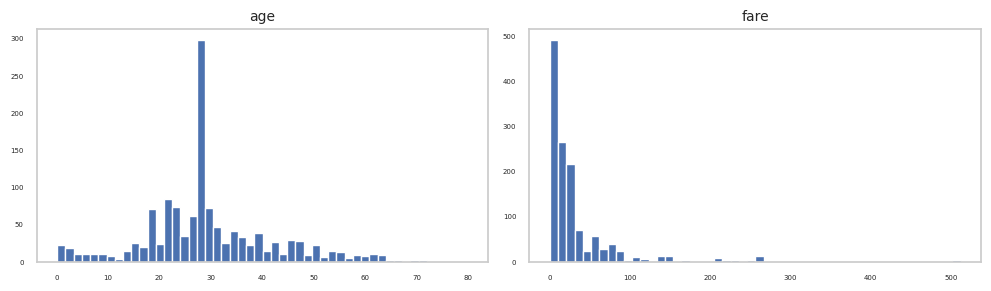

In [ ]:
num_features.hist(figsize=(10, 3), bins=50,xlabelsize=5, ylabelsize=5, grid=False);

Посмотрим на матрицу корреляций с новыми признаками:

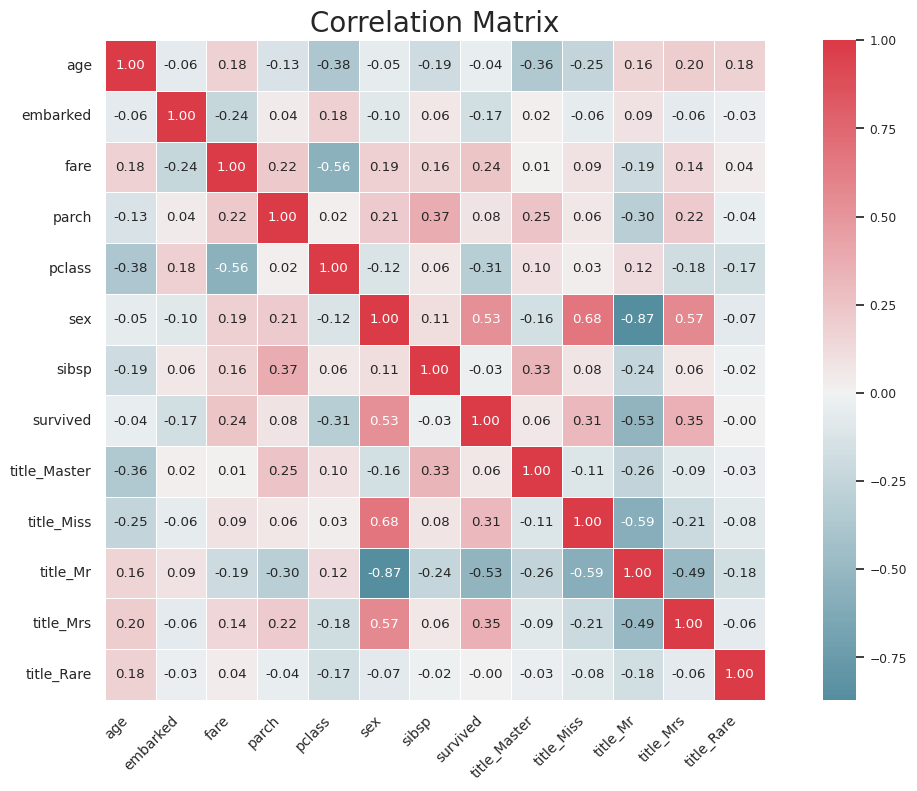

In [ ]:
corrmat = df_encoded.corr()
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot = sns.heatmap(corrmat, annot=True, fmt=".2f", cmap=cmap, center=0, linewidths=0.5, square=True)
plt.title('Correlation Matrix', size=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

Наблюдается сильная корреляция признака sex с новыми признаками, образованными от title -- miss, mr, mrs.

Теперь попробуем проанализировать наши данные в зависимости от нашей целевой переменной:

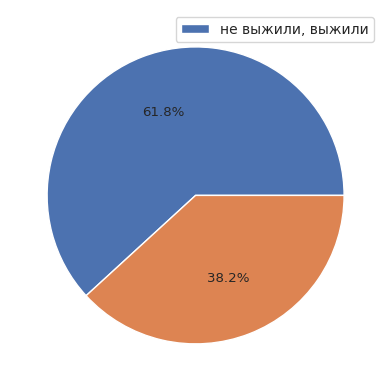

In [ ]:
data = df['survived'].value_counts()
plt.pie(data, autopct='%1.1f%%')
plt.legend(['не выжили, выжили'])
plt.show()

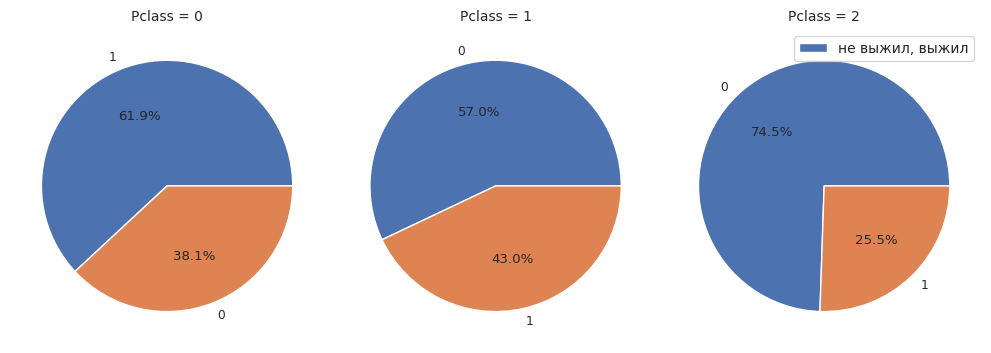

In [ ]:
data1 = df[df['pclass'] == 0]['survived'].value_counts()
data2 = df[df['pclass'] == 1]['survived'].value_counts()
data3 = df[df['pclass'] == 2]['survived'].value_counts()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,8))

ax1.pie(data1.values, labels=data1.index, autopct='%1.1f%%')
ax2.pie(data2.values, labels=data2.index, autopct='%1.1f%%')
ax3.pie(data3.values, labels=data3.index, autopct='%1.1f%%')

ax1.set_title("Pclass = 0")
ax2.set_title("Pclass = 1")
ax3.set_title("Pclass = 2")

plt.legend(['не выжил, выжил'])

plt.show()

Можно заметить, что люди с самым низким классом обслуживания в большей степени не выжили.

Посмотрим теперь, влияли ли пол и возраст на степень выживаемости или нет:

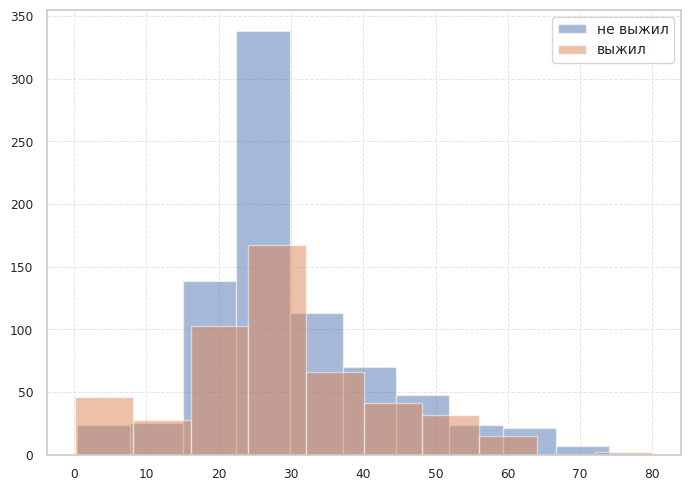

In [ ]:
plt.figure(figsize=(7, 5))

plt.hist(df['age'][df['survived'] == 0], alpha=0.5, label='не выжил')
plt.hist(df['age'][df['survived'] == 1], alpha=0.5, label='выжил')

plt.legend()

plt.show()

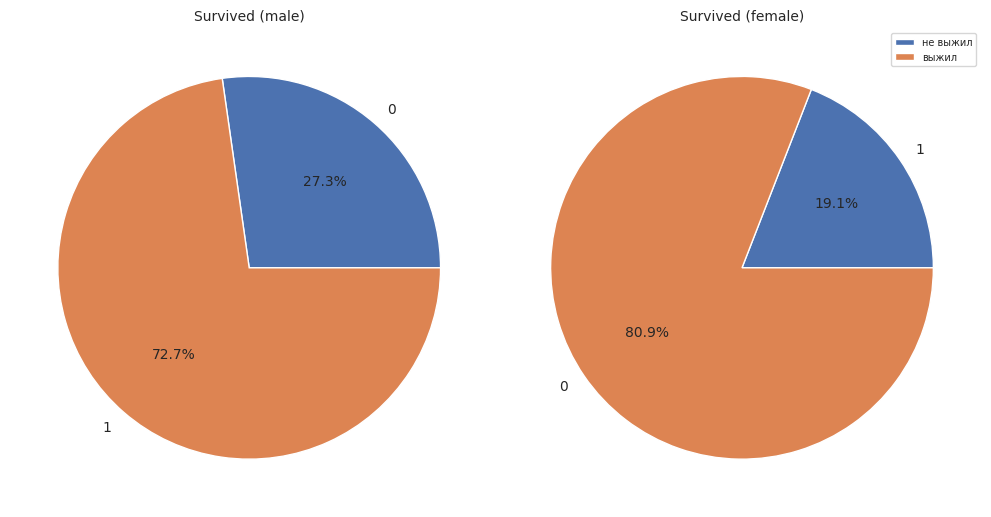

In [ ]:
# female - 0, male - 1
data_1 = df[df['sex']== 1]['survived'].value_counts().sort_values()
data_2 = df[df['sex']== 0]['survived'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

ax1.pie(data_1.values, labels=data_1.index, autopct='%1.1f%%', textprops={'fontsize': 10})
ax2.pie(data_2.values, labels=data_2.index, autopct='%1.1f%%', textprops={'fontsize': 10})

ax1.set_title('Survived (male)', fontsize=10)
ax2.set_title('Survived (female)', fontsize=10)

plt.legend(['не выжил', 'выжил'], fontsize=7)

plt.show()

Можно заметить, что среди женщин процент выживших был больше.

## 3. Нормализация данных относительно среднего и медианы

In [ ]:
pd.set_option('display.max_columns', None)
df_combined

,age,fare,sex,survived,title_Master,title_Miss,title_Mr,title_Mrs,title_Rare,embarked_0,embarked_1,embarked_2,embarked_3,pclass_0,pclass_1,pclass_2,parch_0,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6,parch_9,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,sibsp_8
0,30.0,13.000000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.0,7.925000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,28.0,13.000000,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,73.500000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28.0,7.895800,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,7.312500,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,38.0,71.283302,1,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,41.0,15.045800,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,29.0,9.500000,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Масштабируем данные:

In [ ]:
features_to_normalize = ['age', 'fare']

scaler = StandardScaler()
df_combined[features_to_normalize] = scaler.fit_transform(df_combined[features_to_normalize])

In [ ]:
df_combined.columns

Index(['age', 'fare', 'sex', 'survived', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_Rare', 'embarked_0', 'embarked_1',
       'embarked_2', 'embarked_3', 'pclass_0', 'pclass_1', 'pclass_2',
       'parch_0', 'parch_1', 'parch_2', 'parch_3', 'parch_4', 'parch_5',
       'parch_6', 'parch_9', 'sibsp_0', 'sibsp_1', 'sibsp_2', 'sibsp_3',
       'sibsp_4', 'sibsp_5', 'sibsp_8'],
      dtype='object')

# Обучение модели

## 1. Выбор модели или ансамбля моделей

##### Дополнительно:

In [ ]:
df = df_combined
len_df = len(df)

df_train, df_val, df_test = df.iloc[:int(len_df*0.8)], df.iloc[int(len_df*0.8):int(len_df*0.9)], df.iloc[int(len_df*0.9):]

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
       ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

def prepare_data(element: dict, label: tf.Tensor) -> tuple:
    features_list = [tf.cast(tensor, tf.float32) for tensor in element.values()]
    features_tensor = tf.stack(features_list, axis=0)
    features_tensor = tf.transpose(features_tensor)
    return features_tensor, label

train_ds = df_to_dataset(df_train)
train_ds = train_ds.map(prepare_data)

val_ds = df_to_dataset(df_val, shuffle=False)
val_ds = val_ds.map(prepare_data)

test_ds = df_to_dataset(df_test, shuffle=False)
test_ds = test_ds.map(prepare_data)

##### Основное:

In [ ]:
df_val_1 = df_val.drop('survived', axis=1)
df_test_1 = df_test.drop('survived', axis=1)
df_train_1 = df_train.drop('survived', axis=1)

In [ ]:
y_train = df_train['survived']
y_val = df_val['survived']
y_test = df_test['survived']

In [ ]:
from tensorflow.keras.metrics import F1Score

def create_model(dropout_rate):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(df_train_1.shape[1], )),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid') # бинарная классификация
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # т.к. классификация
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model(0.)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


history = model.fit(
    df_train_1, y_train,
    validation_data=val_ds,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6435 - loss: 0.6389 - val_accuracy: 0.7557 - val_loss: 0.5532
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7526 - loss: 0.5235 - val_accuracy: 0.7939 - val_loss: 0.4914
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7890 - loss: 0.4754 - val_accuracy: 0.8092 - val_loss: 0.4676
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7856 - loss: 0.4729 - val_accuracy: 0.8168 - val_loss: 0.4517
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8329 - loss: 0.4091 - val_accuracy: 0.8168 - val_loss: 0.4453
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8211 - loss: 0.4429 - val_accuracy: 0.8168 - val_loss: 0.4403
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8128 - loss: 0.4371 - val_accuracy: 0.8321 - val_loss: 0.4449
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8390 - loss: 0.3976 - val_accuracy: 0.82

In [ ]:
history.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,196 (32.02 KB)

# Оценка модели

In [ ]:
y_val_pred = model.predict(df_val_1)
y_train_pred = model.predict(df_train_1)
y_test_pred = model.predict(df_test_1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)
f1_scores = 2 * recall * precision / (recall + precision+10**-10)

opt_threshold_idx = np.argmax(f1_scores)
opt_threshold = thresholds[opt_threshold_idx]
opt_threshold

0.38745308

In [ ]:
y_train_pred_ = (y_train_pred >= opt_threshold).astype(int)
y_val_pred_ = (y_val_pred >= opt_threshold).astype(int)
y_test_pred_ = (y_test_pred >= opt_threshold).astype(int)

# 1. Получение F1-метрики на тестовом наборе данных

In [ ]:
f1_score(y_test, y_test_pred_)

0.8130081300813008

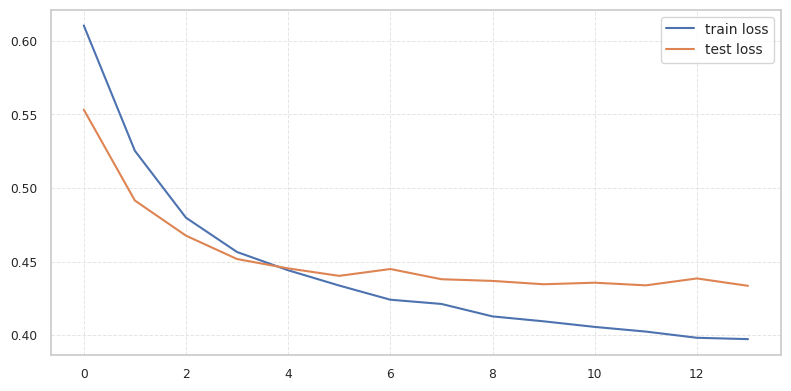

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();